In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, log_loss

import xgboost as xgb

/opt/ds/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("./train.csv")
test_df    = pd.read_csv("./test.csv")

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

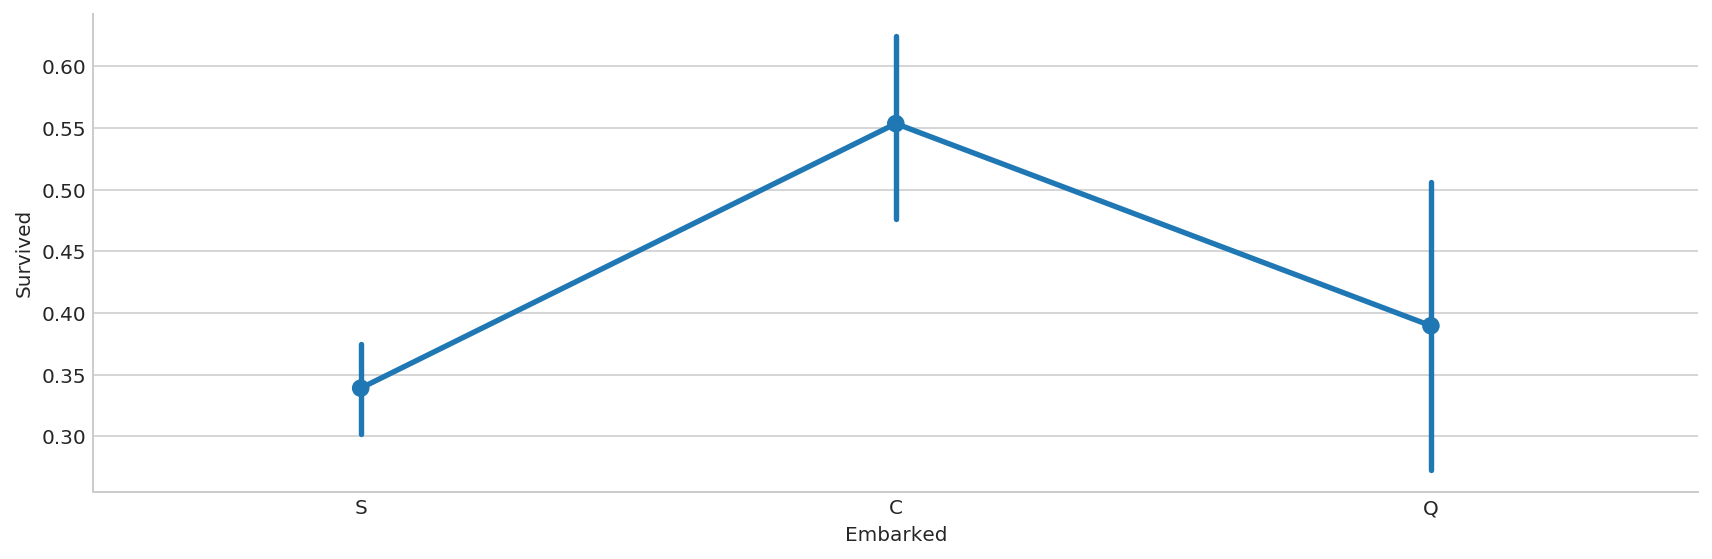

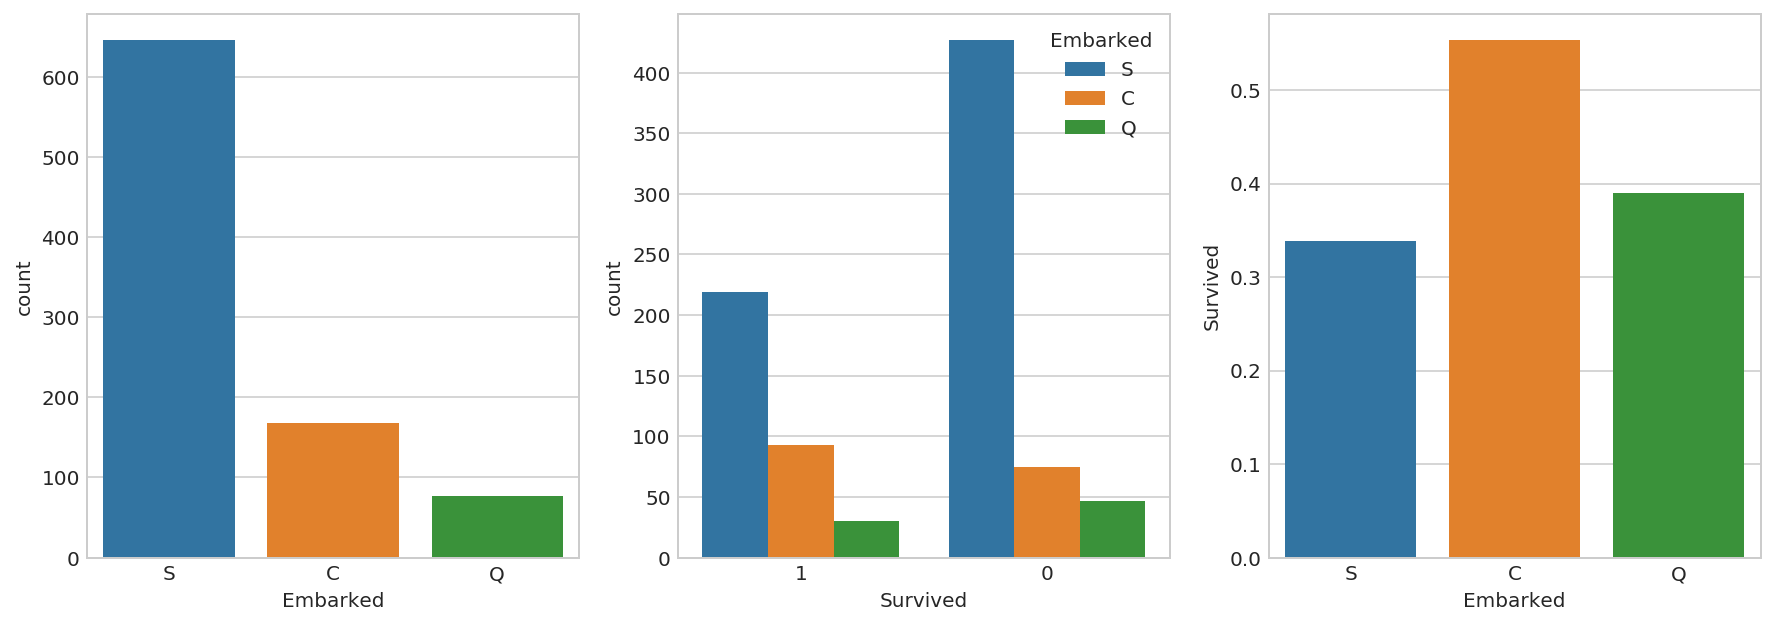

In [4]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

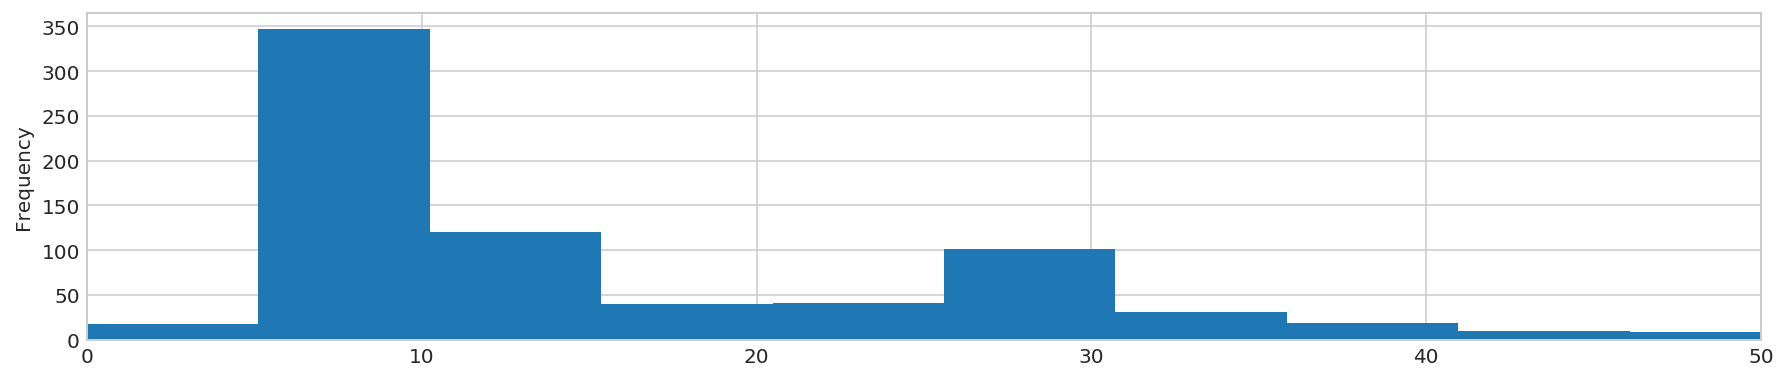

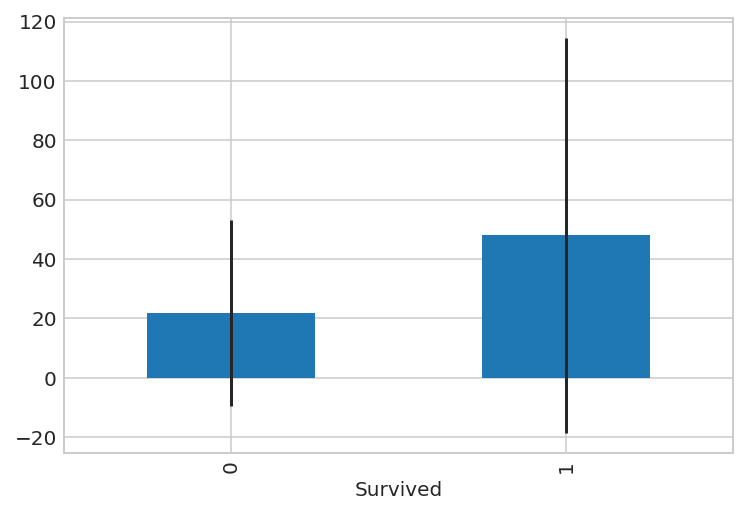

In [5]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

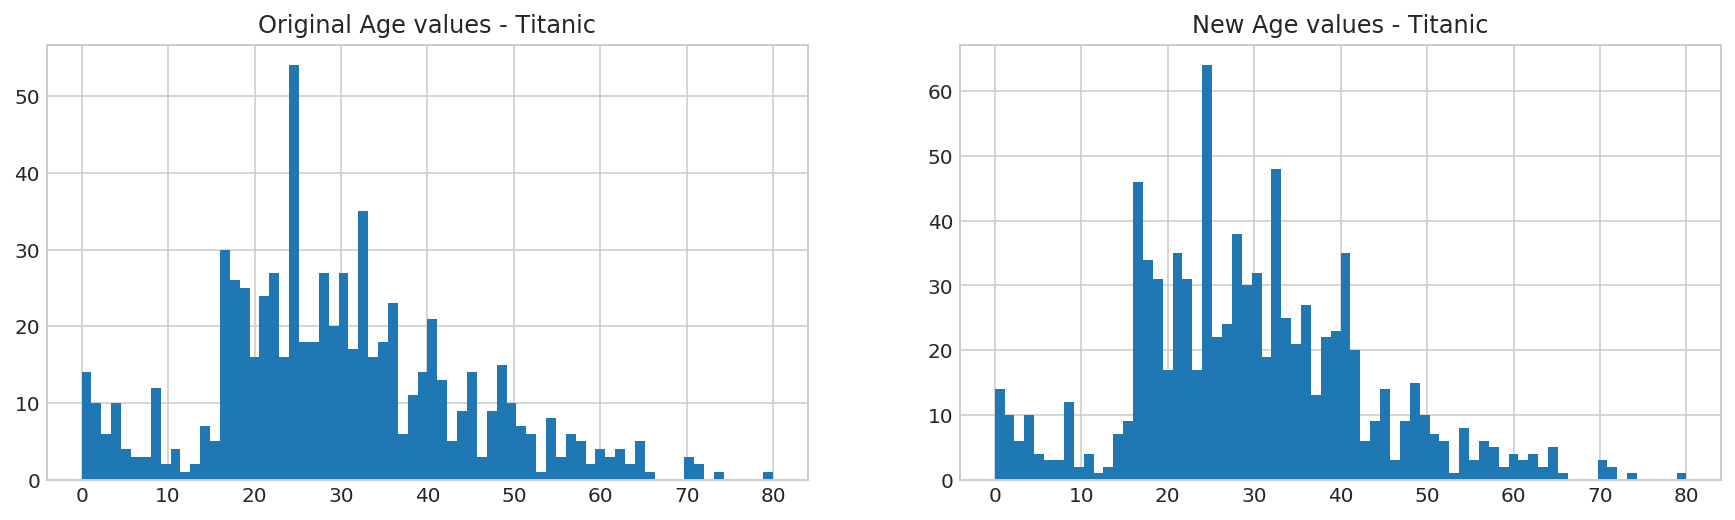

In [6]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df.loc[np.isnan(titanic_df["Age"]), "Age"] = rand_1
test_df.loc[np.isnan(test_df["Age"]), "Age"] = rand_2

# convert from float to int
titanic_df.loc[:, 'Age'] = titanic_df['Age'].astype(int)
test_df.loc[:, 'Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

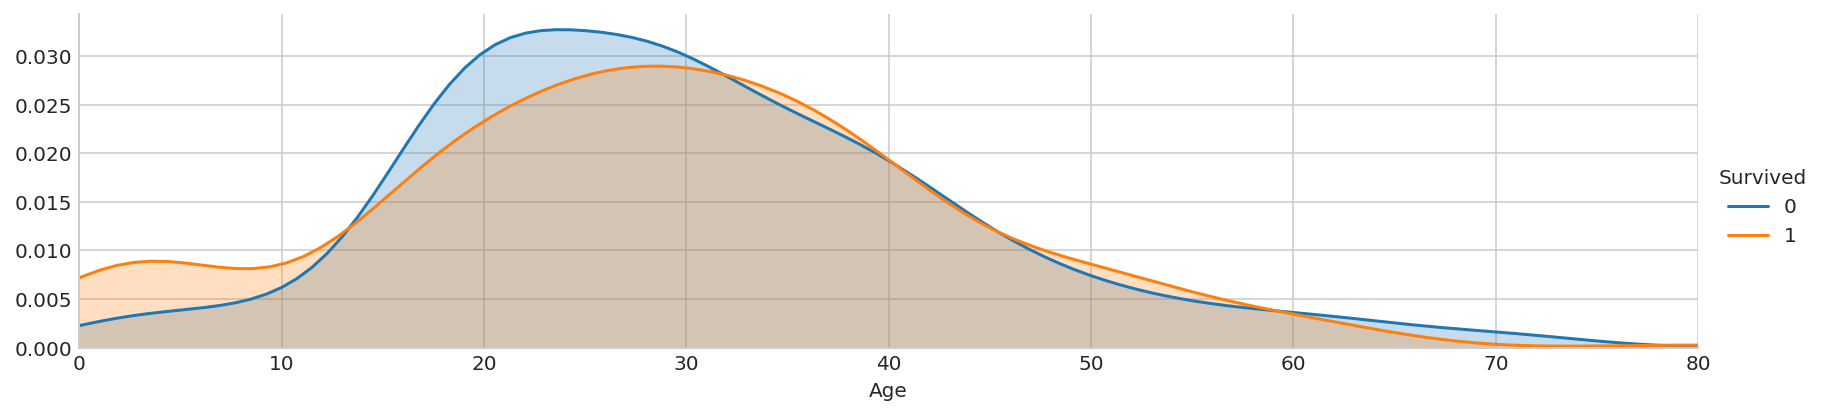

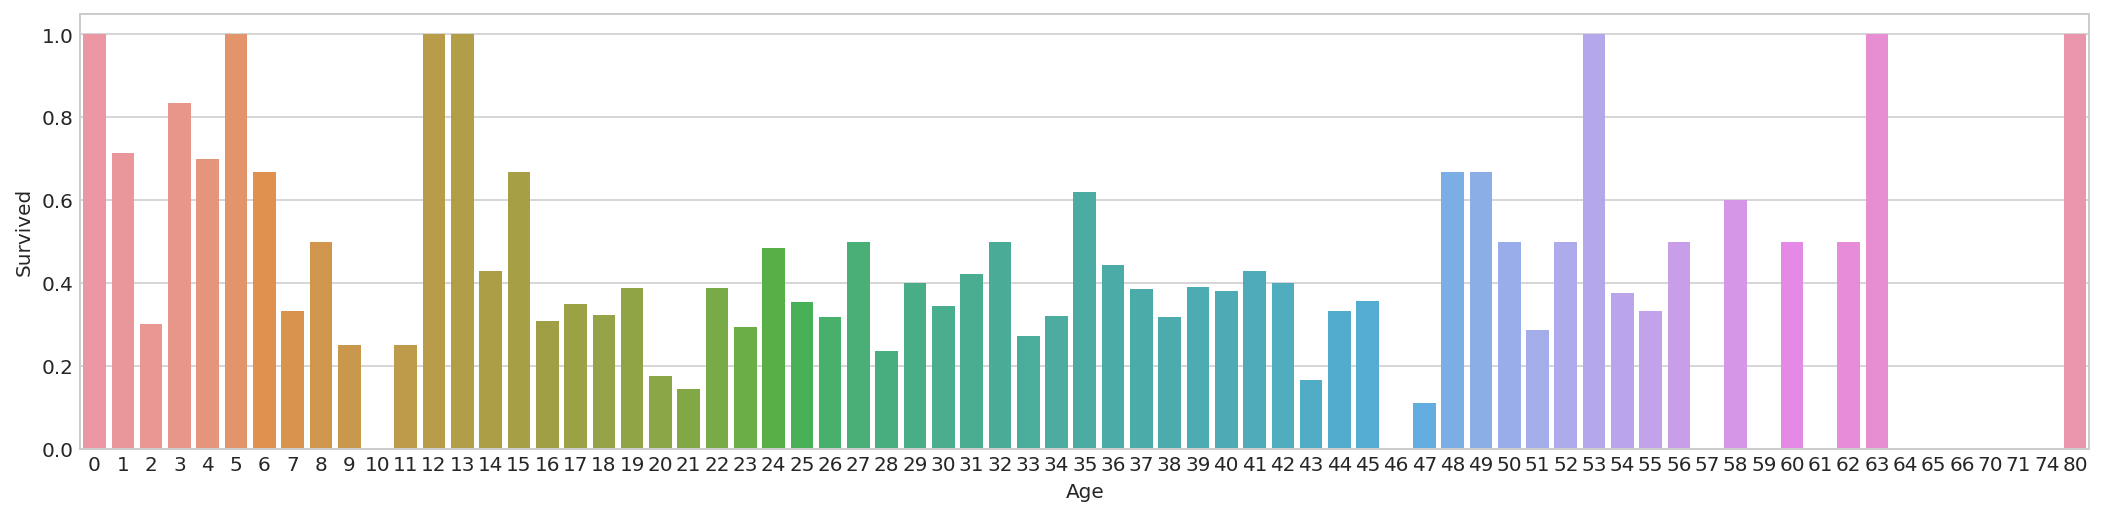

In [7]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [8]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

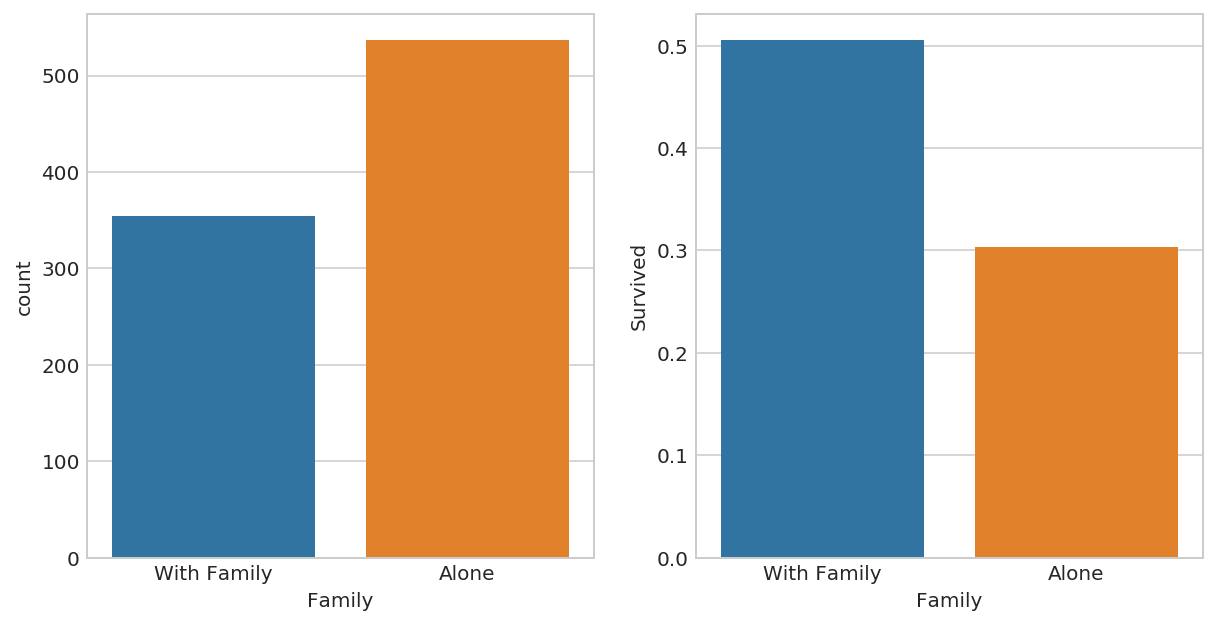

In [9]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df.loc[:, 'Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df.loc[titanic_df['Family'] > 0, 'Family'] = 1
titanic_df.loc[titanic_df['Family'] == 0, 'Family'] = 0

test_df.loc[:, 'Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df.loc[titanic_df['Family'] > 0, 'Family'] = 1
test_df.loc[titanic_df['Family'] == 0, 'Family'] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

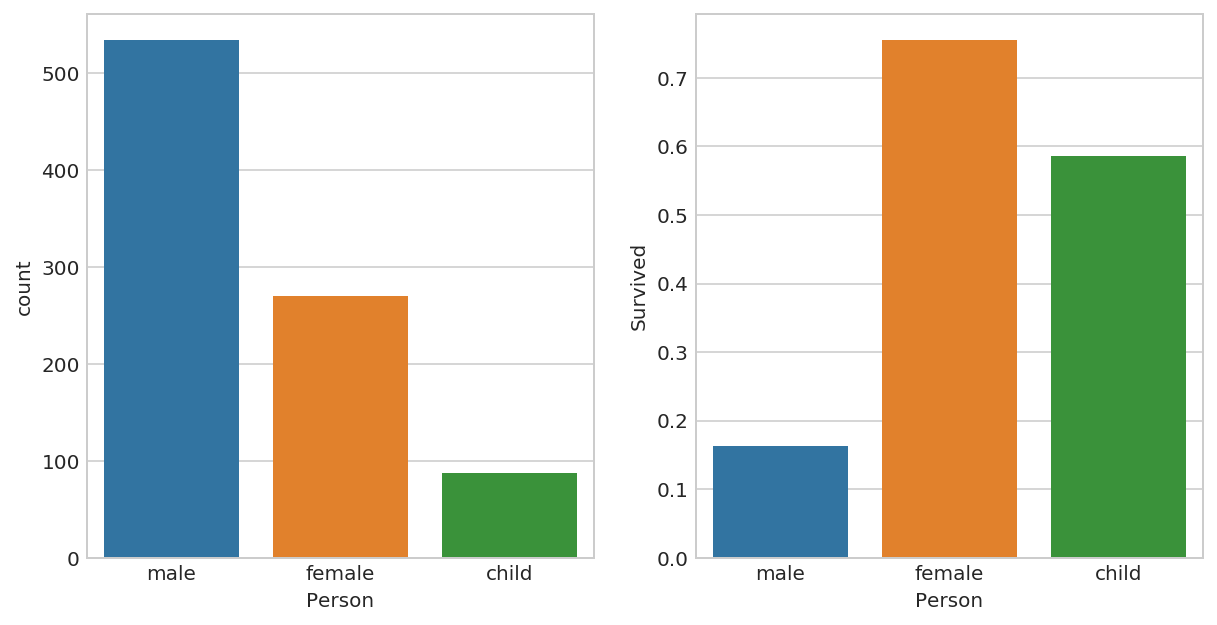

In [10]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

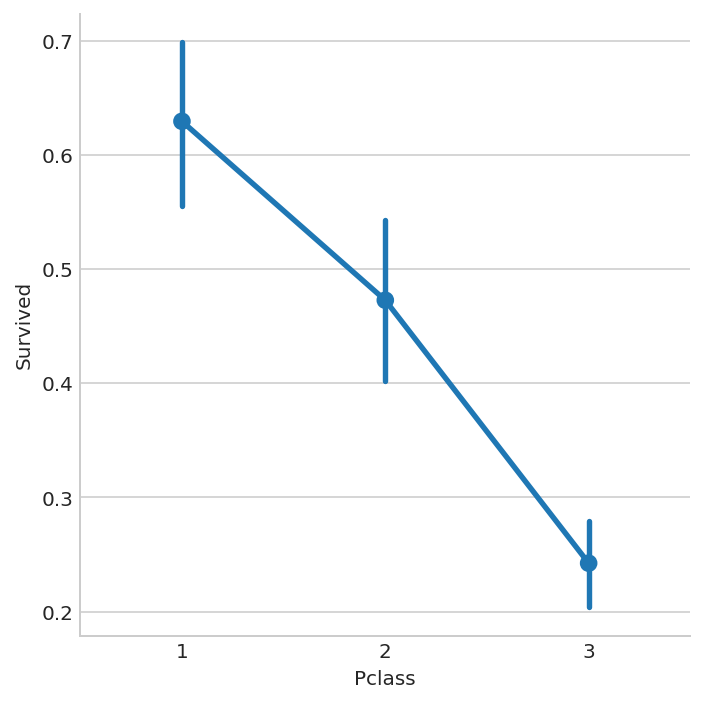

In [11]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [12]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [13]:
X_train.head()

,Age,Fare,C,Q,Family,Child,Female,Class_1,Class_2
0,22,7,0,0,1,0,0,0,0
1,38,71,1,0,1,0,1,1,0
2,26,7,0,0,0,0,1,0,0
3,35,53,0,0,1,0,1,1,0
4,35,8,0,0,0,0,0,0,0


In [14]:
skf = StratifiedKFold(n_splits=4, random_state=0)

In [15]:
accuracies = []
for train, test in skf.split(X_train, y_train):
    sub_train = X_train.iloc[train]
    train_label = y_train.iloc[train]
    sub_test = X_train.iloc[test]
    test_label = y_train.iloc[test]
    
    logreg = LogisticRegression()
    logreg.fit(sub_train, train_label)
    y_pred = logreg.predict(sub_test)
    print(accuracy_score(test_label, y_pred))
    accuracies.append(accuracy_score(test_label, y_pred))
    
print('accuracy = {:.5f} ± {:.5f}'.format(np.mean(accuracies), np.std(accuracies)))

0.803571428571
0.807174887892
0.779279279279
0.824324324324
accuracy = 0.80359 ± 0.01608


In [16]:
preds = logreg.predict_proba(sub_test)

In [17]:
preds

array([[ 0.29765317,  0.70234683],
       [ 0.79459021,  0.20540979],
       [ 0.91052561,  0.08947439],
       [ 0.11840105,  0.88159895],
       [ 0.25639232,  0.74360768],
       [ 0.77650446,  0.22349554],
       [ 0.89297143,  0.10702857],
       [ 0.90350903,  0.09649097],
       [ 0.35620733,  0.64379267],
       [ 0.53756552,  0.46243448],
       [ 0.84074485,  0.15925515],
       [ 0.35586329,  0.64413671],
       [ 0.49990554,  0.50009446],
       [ 0.89706397,  0.10293603],
       [ 0.64507356,  0.35492644],
       [ 0.88381147,  0.11618853],
       [ 0.68846599,  0.31153401],
       [ 0.64015298,  0.35984702],
       [ 0.89560902,  0.10439098],
       [ 0.89297143,  0.10702857],
       [ 0.31146249,  0.68853751],
       [ 0.68233591,  0.31766409],
       [ 0.43100334,  0.56899666],
       [ 0.90805862,  0.09194138],
       [ 0.84097287,  0.15902713],
       [ 0.7410315 ,  0.2589685 ],
       [ 0.83733355,  0.16266645],
       [ 0.93158064,  0.06841936],
       [ 0.27471799,

In [18]:
fpr, tpr, _ = roc_curve(test_label, preds[:, 1])
roc_auc = roc_auc_score(test_label, preds[:, 1])

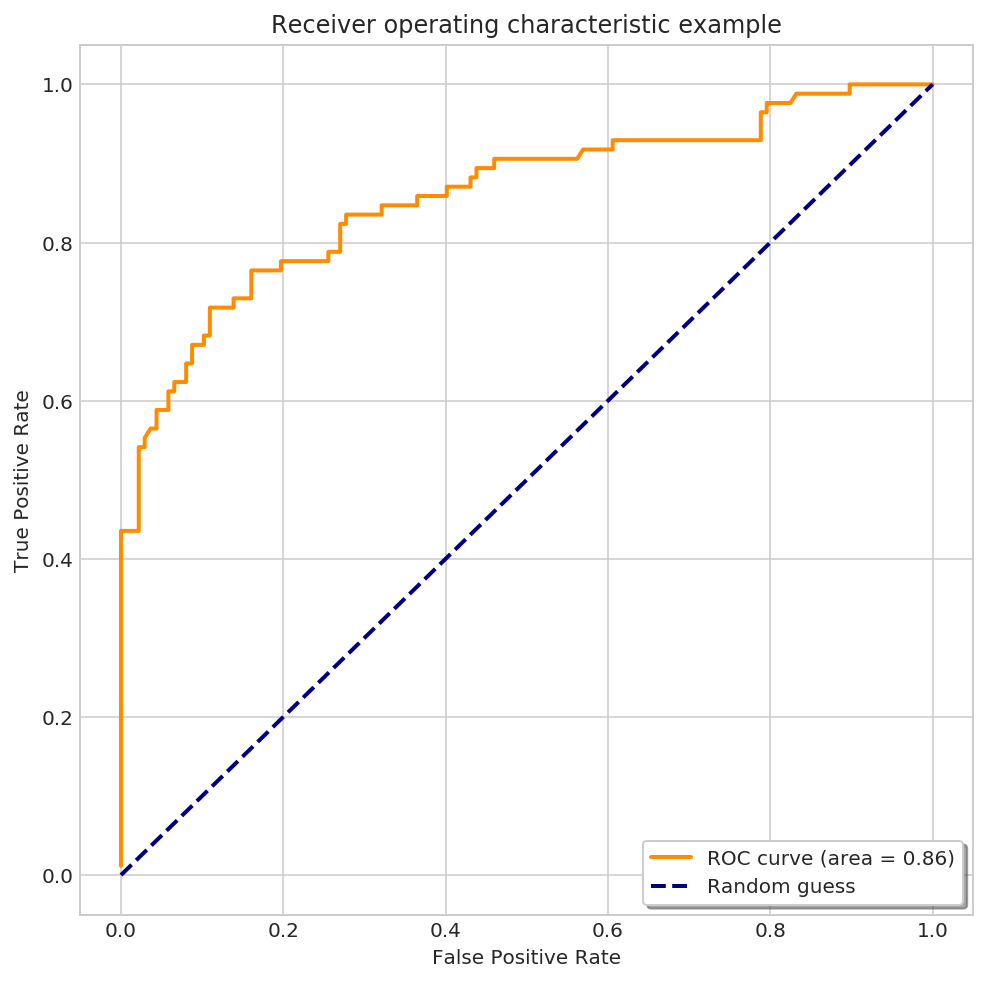

In [19]:
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random guess')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", frameon=True, framealpha=1., shadow=1.)
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
stsc = StandardScaler()
stsc.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
X_train_old = X_train.copy()
X_train = stsc.transform(X_train)

In [23]:
results_l2 = []
space = [.0001, .001, .01, .1, 1., 10., 100., 1000., 10000.]
for reg_param in space:
    accuracies = []
    for train, test in skf.split(X_train, y_train):
        sub_train = X_train[train]
        train_label = y_train.iloc[train]
        sub_test = X_train[test]
        test_label = y_train.iloc[test]

        logreg = LogisticRegression(penalty='l2', C=reg_param, random_state=0)
        logreg.fit(sub_train, train_label)
        y_pred = logreg.predict(sub_test)
        accuracies.append(accuracy_score(test_label, y_pred))
    results_l2.append(accuracies)

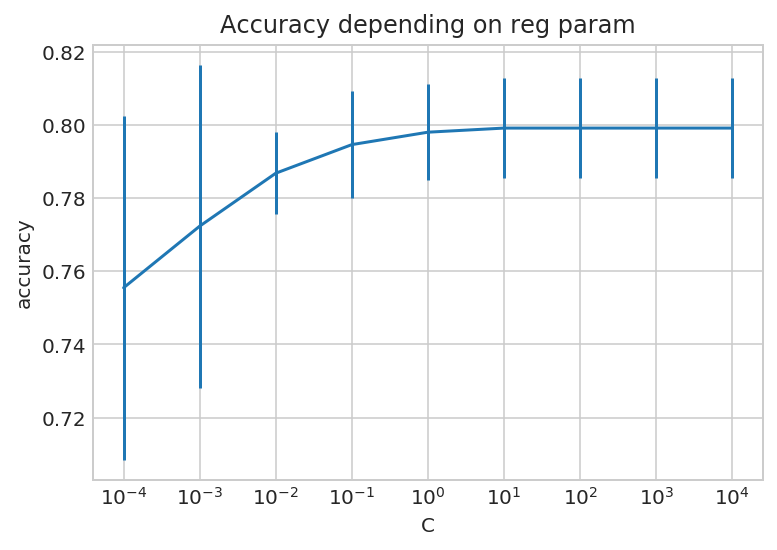

In [24]:
ax = plt.axes()
ax.errorbar(space, [np.mean(i) for i in results_l2], 
            yerr=[np.std(i) for i in results_l2])
ax.set_xscale('log')
ax.set_title('Accuracy depending on reg param')
ax.set_ylabel('accuracy')
ax.set_xlabel('C');

In [25]:
results_l1 = []
space = [.0001, .001, .01, .1, 1., 10., 100., 1000., 10000.]
for reg_param in space:
    accuracies = []
    for train, test in skf.split(X_train, y_train):
        sub_train = X_train[train]
        train_label = y_train.iloc[train]
        sub_test = X_train[test]
        test_label = y_train.iloc[test]

        logreg = LogisticRegression(penalty='l1', C=reg_param, random_state=0)
        logreg.fit(sub_train, train_label)
        y_pred = logreg.predict(sub_test)
        accuracies.append(accuracy_score(test_label, y_pred))
    results_l1.append(accuracies)

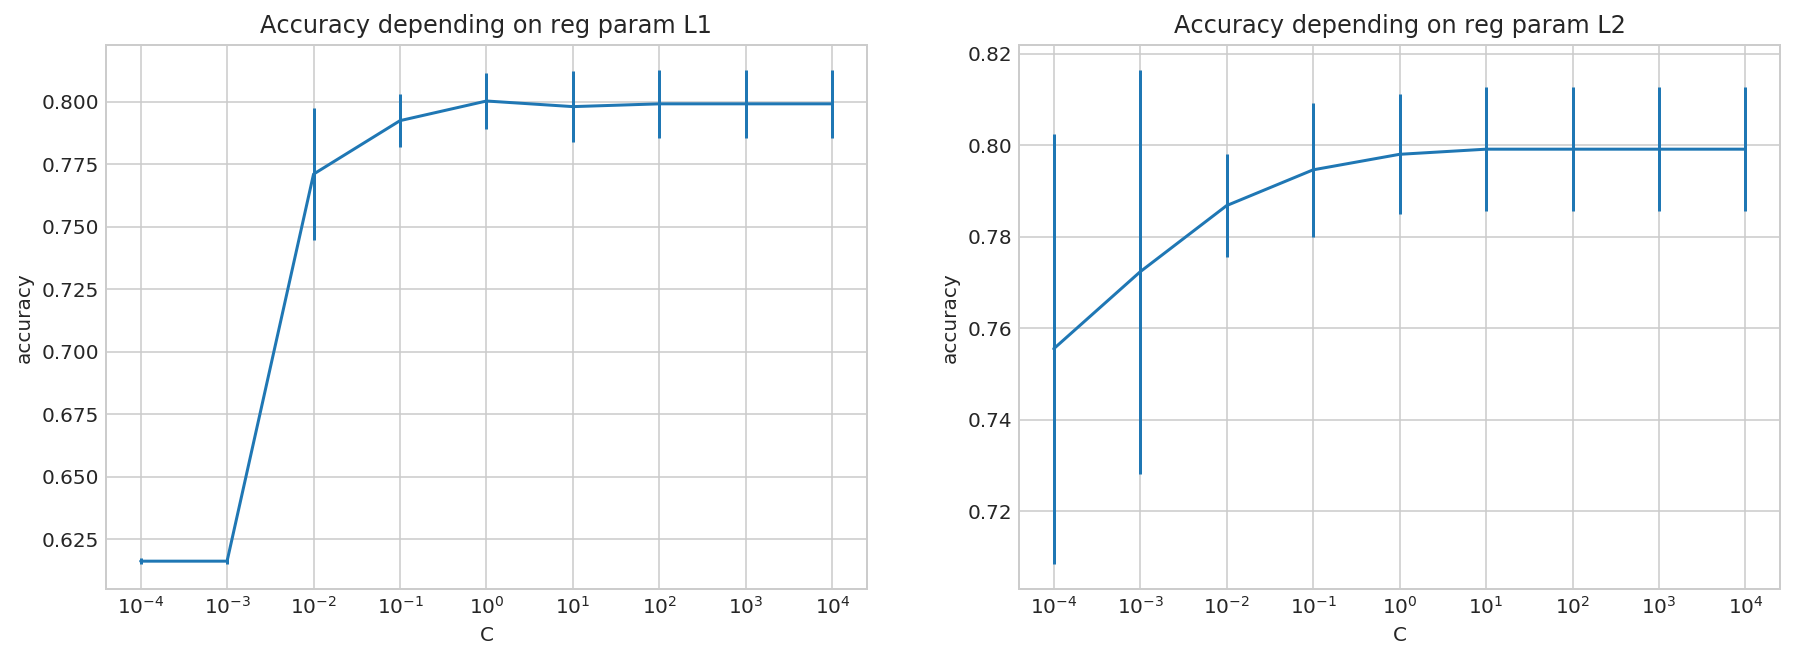

In [26]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
# ax = plt.axes()
ax.errorbar(space, [np.mean(i) for i in results_l1], 
            yerr=[np.std(i) for i in results_l1])
ax.set_xscale('log')
ax.set_title('Accuracy depending on reg param L1')
ax.set_ylabel('accuracy')
ax.set_xlabel('C')

ax = plt.subplot(1, 2, 2)
# ax = plt.axes()
ax.errorbar(space, [np.mean(i) for i in results_l2], 
            yerr=[np.std(i) for i in results_l2])
ax.set_xscale('log')
ax.set_title('Accuracy depending on reg param L2')
ax.set_ylabel('accuracy')
ax.set_xlabel('C')

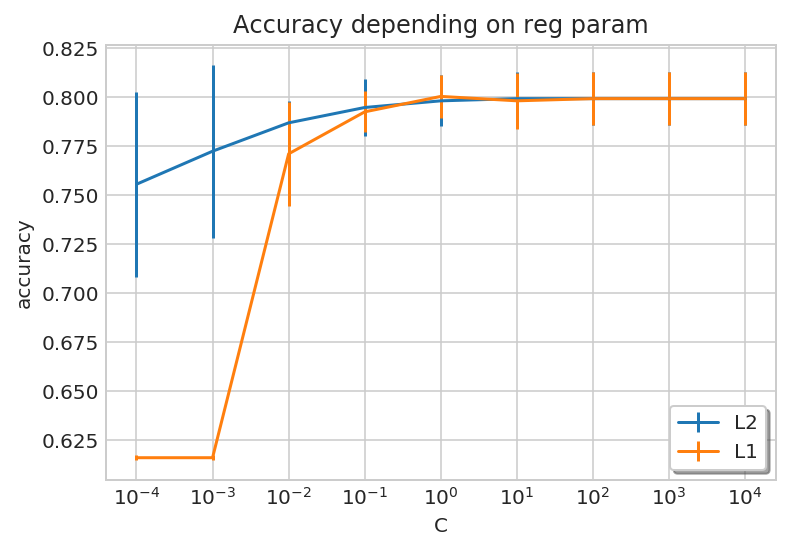

In [27]:
ax = plt.axes()
ax.errorbar(space, [np.mean(i) for i in results_l2], 
            yerr=[np.std(i) for i in results_l2], label='L2')
ax.errorbar(space, [np.mean(i) for i in results_l1], 
            yerr=[np.std(i) for i in results_l1], label='L1')
ax.set_xscale('log')
ax.legend(loc="lower right", frameon=True, framealpha=1., shadow=1.)
ax.set_title('Accuracy depending on reg param')
ax.set_ylabel('accuracy')
ax.set_xlabel('C');

In [28]:
results_l2 = []
space = [.0001, .001, .01, .1, 1., 10., 100., 1000., 10000.]
for reg_param in space:
    roc_aucs = []
    for train, test in skf.split(X_train, y_train):
        sub_train = X_train[train]
        train_label = y_train.iloc[train]
        sub_test = X_train[test]
        test_label = y_train.iloc[test]

        logreg = LogisticRegression(penalty='l2', C=reg_param, random_state=0)
        logreg.fit(sub_train, train_label)
        y_pred = logreg.predict_proba(sub_test)[:, 1]
        roc_aucs.append(roc_auc_score(test_label, y_pred))
    results_l2.append(roc_aucs)

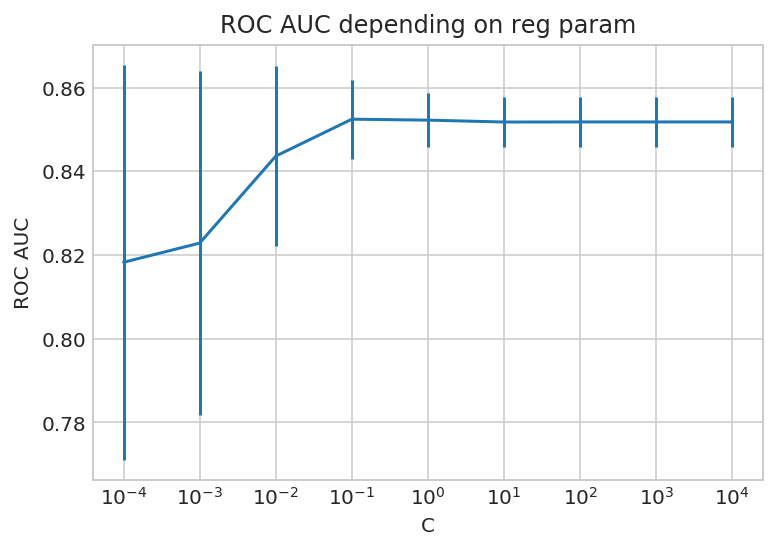

In [29]:
ax = plt.axes()
ax.errorbar(space, [np.mean(i) for i in results_l2], 
            yerr=[np.std(i) for i in results_l2])
ax.set_xscale('log')
ax.set_title('ROC AUC depending on reg param')
ax.set_ylabel('ROC AUC')
ax.set_xlabel('C');

In [30]:
from tqdm import tqdm

In [31]:
results = []
space = np.arange(1, 50, 1)
for param in tqdm(space):
    accuracies = []
    for train, test in skf.split(X_train_old, y_train):
        sub_train = X_train_old.iloc[train]
        train_label = y_train.iloc[train]
        sub_test = X_train_old.iloc[test]
        test_label = y_train.iloc[test]

        rf = RandomForestClassifier(n_estimators=param, random_state=0, n_jobs=-1)
        rf.fit(sub_train, train_label)
        y_pred = rf.predict(sub_test)
        accuracies.append(accuracy_score(test_label, y_pred))
    results.append(accuracies)

100%|██████████| 49/49 [00:44<00:00,  1.05it/s]


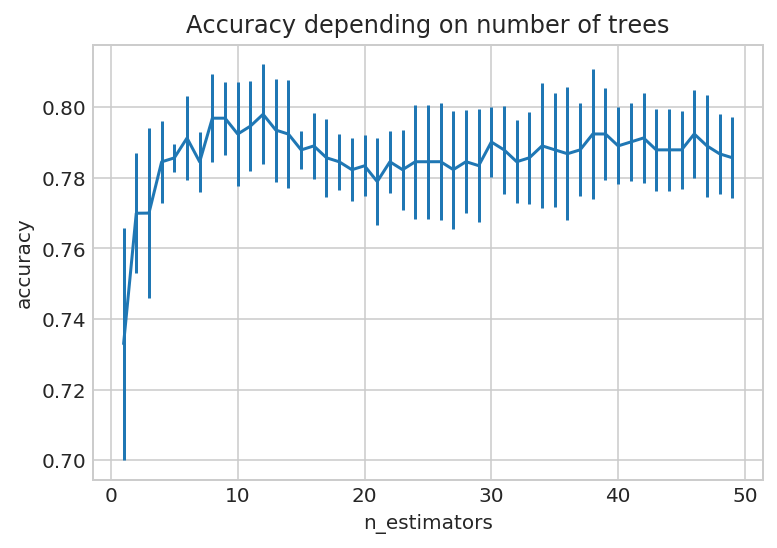

In [32]:
ax = plt.axes()
ax.errorbar(space, [np.mean(i) for i in results], 
            yerr=[np.std(i) for i in results])
# ax.set_xscale('log')
ax.set_title('Accuracy depending on number of trees')
ax.set_ylabel('accuracy')
ax.set_xlabel('n_estimators');

In [33]:
results = []
space = np.arange(1, 50, 1)
for param in tqdm(space):
    roc_aucs = []
    for train, test in skf.split(X_train_old, y_train):
        sub_train = X_train_old.iloc[train]
        train_label = y_train.iloc[train]
        sub_test = X_train_old.iloc[test]
        test_label = y_train.iloc[test]

        rf = RandomForestClassifier(n_estimators=param, random_state=0, n_jobs=-1)
        rf.fit(sub_train, train_label)
        y_pred = rf.predict(sub_test)
        roc_aucs.append(roc_auc_score(test_label, y_pred))
    results.append(roc_aucs)

100%|██████████| 49/49 [00:44<00:00,  1.05it/s]


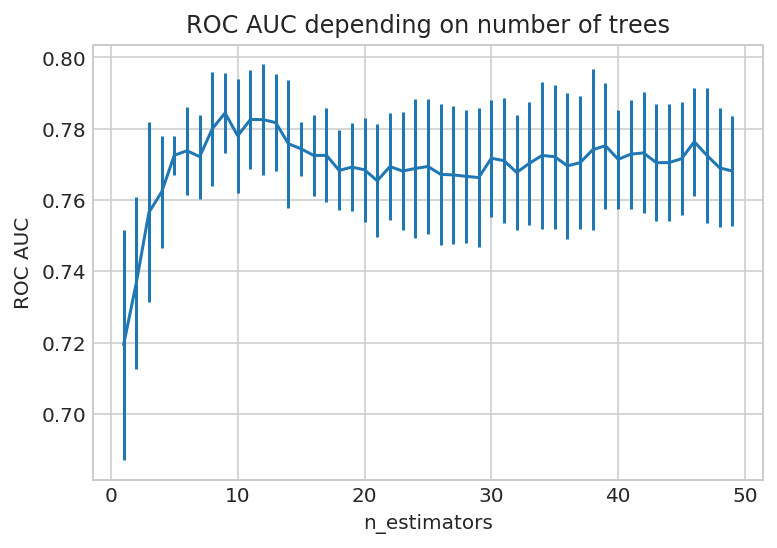

In [34]:
ax = plt.axes()
ax.errorbar(space, [np.mean(i) for i in results], 
            yerr=[np.std(i) for i in results])
# ax.set_xscale('log')
ax.set_title('ROC AUC depending on number of trees')
ax.set_ylabel('ROC AUC')
ax.set_xlabel('n_estimators');